In [1]:
# conda install -c conda-forge python-graphvi
# 

from CO2xSWV import fetch_data_from_NEON_API, make_df
import pandas as pd
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import numpy as np
import multiprocessing
from dataclasses import dataclass
import xarray as xr
import scipy.stats as stats

from dask import delayed
import dask
from dask.diagnostics import ProgressBar

multiprocessing.cpu_count()

40

In [2]:
sitecodes = ['BART', 'ABBY', 'TEAK','GRSM', 'MLBS', 'ORNL', 'DELA', 'LENO', 'TALL', 'DCFS']
#sitecodes = ['BART']

productcodes = ['DP1.00095.001', 'DP1.00094.001','DP1.00041.001']
daterange = ['2015-01', '2020-11']
data_path='/home/jovyan/NEON/CO2xSWV_data'
#fetch_data_from_NEON_API(sitecodes, productcodes, daterange=daterange, data_path=data_path)
# TODO: optimize dask for cyverse

In [45]:
from CO2xSWV import viable_hours
metadict = viable_hours(['TALL'], data_path)

In [70]:
from CO2xSWV import print_hours
print_hours(metadict)

TALL - 001502 has 8176 entries
TALL - 001503 has 8176 entries
TALL - 001501 has 8176 entries
TALL - 002503 has 8176 entries
TALL - 002501 has 8176 entries
TALL - 002502 has 8176 entries
TALL - 003502 has 8176 entries
TALL - 003501 has 8176 entries
TALL - 003503 has 8176 entries
TALL - 004501 has 8176 entries
TALL - 004502 has 8176 entries
TALL - 004503 has 8176 entries
TALL - 005502 has 8176 entries
TALL - 005501 has 8176 entries
TALL - 005503 has 8176 entries


In [5]:
from CO2xSWV import make_hours_df
hourly = make_hours_df(metadict)


cols = list(hourly.columns)
fig, axs = plt.subplots(len(cols), figsize=(15, 100))
for i, col in enumerate(cols):
    axs[i].scatter(hourly.index, hourly[col]);
    axs[i].title.set_text(col)

In [48]:
import dask.dataframe as dd

def make_pooled_hourly_data_parquet(): # args to come
    '''Aggregates available hourly data for all sites into a parquet for fast reading later.
    Requires pyarrow (pip install pyarrow).
    '''
    # get sensor position info 
    c02_sensor_pos, h20_sensors_pos, temp_sensors_pos = get_sensor_positions(site)

    #TODO:loops and whatnot
    
    
    
    # repartition to 100 MB
    with ProgressBar():
        ddf.repartition(partition_size='100MB')
    # write to parquet 
    
    
def get_sensor_positions(site):
    '''Returns Pandas.DataFrame of sensor position info for 
    DP1.00095.001, DP1.00094.001 , and  DP1.00041.001'''
    co2 = glob.glob(f'{data_path}/*{site}.DP1.00095.001.sensor_positions.*csv')[0]
    h2o = glob.glob(f'{data_path}/*{site}.DP1.00094.001.sensor_positions.*csv')[0]
    t_s = glob.glob(f'{data_path}/*{site}.DP1.00041.001.sensor_positions.*csv')[0]
    
    try:
        co2 = pd.read_csv(co2, dtype={'HOR.VER': 'str'})
        h2o = pd.read_csv(h2o, dtype={'HOR.VER': 'str'})
        t_s = pd.read_csv(t_s, dtype={'HOR.VER': 'str'})
        return(co2, h2o, t_s)
    
    except FileNotFoundError:
        print('FileNotFoundError:\nTry downloading the files with CO2xSWV.sensor_positions() first')
    
def get_specific_posotion(hor):
    '''Returns location data for the specific sensor'''
    
    
def make_df_for_horver(hor, ver, dates, site, data_path):
    '''retuns uncomputed dask df of hourly data for hor, ver, site'''
    dfs = []
    for date in dates:
        try:
            dfs.append(make_ddf(date, site, data_path))
        except IndexError:
            print(f'No file found for {date}')
    ddf = dd.concat(dfs)
    return(ddf)

def make_ddf(date, site, data_path):
    '''Reads  NEON 1 minute cvs for:
           DP1.00094.001  (Soil CO2 concentrations)
           DP1.00041.001  (Soil Temperature)
           DP1.00095.001  (soil volumetric water content and salinity)
       drops entries with bad finalQF flags,
       drops quality metric columns,
       and returns an uncomputed dask dataframe of merged data.
    
    Arguments:
    hor  -- String - horizontal sensor position (HOR in the 
            NEON product readme files).
    ver  -- String - vertical sensor position   (VER in the 
            NEON product readme files).
    date -- String - month of data desired. (yyyy-mm)
    site -- String - NOEN site code (e.g. 'BART')
    data_path -- String - path to data.
    
    '''
    # glob the filenames, only one gets globbed for each
    minute = '[0-9]' * 3 + '.' + '[0-9]' * 3 + '.001' 
    co2 = glob.glob(f'{data_path}/*{site}.DP1.00095.001.{minute}.*.{date}.*csv')[0]
    h2o = glob.glob(f'{data_path}/*{site}.DP1.00094.001.{minute}.*.{date}.*csv')[0]
    t   = glob.glob(f'{data_path}/*{site}.DP1.00041.001.{minute}.*.{date}.*csv')[0]
    
    # make CO2 ddf
    co2 = dd.read_csv(co2, parse_dates=True, 
                      dtype={'soilCO2concentrationNumPts': 'float64'}).set_index('startDateTime')
    # Fail and pass columns are redundent, we will use the fails
    drops = [col for col in list(co2.columns) if 'Pass' in col]
    co2 = co2.drop(drops, axis='columns')
    # drop columns with bad quality flags
    co2 = co2.loc[co2.finalQF == 0]
    # now drop quality metric columns
    qm = [col for col in list(co2.columns) if 'QM' in col]
    qm = qm + [col for col in list(co2.columns) if 'QF' in col] + ['endDateTime']
    co2 = co2.drop(qm, axis='columns')
    #this following step should not be needed, but just in case
    co2 = co2.dropna()
    # make sure npartitions is always the same for future concatination
    co2 = co2.repartition(npartitions=200)
    
    
    # make H2O ddf
    h2o = dd.read_csv(h2o, parse_dates=True,
                     dtype={'VSICNumPts': 'float64',
                            'VSWCNumPts': 'float64'}).set_index('startDateTime')
    # Fail and pass columns are redundent, we will use the fails
    drops = [col for col in list(h2o.columns) if 'Pass' in col]
    h2o = h2o.drop(drops, axis='columns')
    # drop columns with bad quality flags
    h2o = h2o.loc[(h2o.VSWCFinalQF == 0) & (h2o.VSICFinalQF == 0)]
    # now drop quality metric columns
    qm = [col for col in list(h2o.columns) if 'QM' in col]
    qm = qm + [col for col in list(h2o.columns) if 'QF' in col] + ['endDateTime']
    h2o = h2o.drop(qm, axis='columns')
    #this following step should not be needed, but just in case
    h2o = h2o.dropna()
    # make sure npartitions is always the same for future concatination
    h2o = h2o.repartition(npartitions=200)
    
    co2 = co2.merge(h2o, left_index=True, right_index=True)
    
    # make H2O ddf
    soil_T = dd.read_csv(t, parse_dates=True,
                        dtype={'soilTempNumPts': 'float64'}).set_index('startDateTime')
    # Fail and pass columns are redundent, we will use the fails
    drops = [col for col in list(soil_T.columns) if 'Pass' in col]
    soil_T = soil_T.drop(drops, axis='columns')
    # drop columns with bad quality flags
    soil_T = soil_T.loc[soil_T.finalQF == 0]
    # now drop quality metric columns
    qm = [col for col in list(soil_T.columns) if 'QM' in col]
    qm = qm + [col for col in list(soil_T.columns) if 'QF' in col] + ['endDateTime']
    soil_T = soil_T.drop(qm, axis='columns')
    #this following step should not be needed, but just in case
    soil_T = soil_T.dropna()
    # make sure npartitions is always the same for future concatination
    soil_T = soil_T.repartition(npartitions=200)
    
    co2 = co2.merge(soil_T, left_index=True, right_index=True)
    
    return(co2)

dates = ['2015-10', '2020-11']
hor = '003'
ver ='502'
site = 'TALL'

ddf = make_df_for_horver(hor, ver, dates, site, data_path)

No file found for 2015-10


In [49]:
with ProgressBar():
    ddf.repartition(partition_size='100MB')

[########################################] | 100% Completed |  1min 37.7s


In [24]:
with ProgressBar():
    ddf.to_parquet('test.parquet')

[########################################] | 100% Completed |  3min 16.8s


In [20]:
with ProgressBar():
    df = ddf.compute()

[########################################] | 100% Completed |  3min 15.8s


In [34]:
import time


t0 = time.time()
df.to_parquet('pd_test.parquet')
dt = time.time() - t0
print(f'took {dt/60:.3f} minutes')

took 0.003 minutes


In [41]:
t0 = time.time()
dfx = pd.read_parquet('pd_test.parquet')
t1 = time.time()
dt1 = t1 - t0
dfy = pd.read_parquet('test.parquet')
dt2 = time.time() - t1
print(f'from pd took {dt1:.3f}\nfrom dask took {dt2:.3f}')

from pd took 0.054
from dask took 0.310


In [33]:
# this is like diff
merged = dfy.merge(dfx, indicator=True, how='outer')
merged[merged['_merge'] == 'right_only']

,soilCO2concentrationMean,soilCO2concentrationMinimum,soilCO2concentrationMaximum,soilCO2concentrationVariance,soilCO2concentrationNumPts,soilCO2concentrationExpUncert,soilCO2concentrationStdErMean,VSWCMean,VSWCMinimum,VSWCMaximum,...,VSICExpUncert,VSICStdErMean,soilTempMean,soilTempMinimum,soilTempMaximum,soilTempVariance,soilTempNumPts,soilTempExpUncert,soilTempStdErMean,_merge


In [37]:
df.memory_usage().sum() / 10**6

15.513448

In [7]:
c, w, t = get_offset_dfs(hor, ver, site)

In [8]:
c.head()

,HOR.VER,name,description,start,end,referenceName,referenceDescription,referenceStart,referenceEnd,xOffset,yOffset,zOffset,pitch,roll,azimuth,referenceLatitude,referenceLongitude,referenceElevation
0,001.501,CFGLOC108745,"Talladega National Forest Soil CO2 SP1, Depth 1",2010-01-01T00:00:00Z,2020-01-30T23:59:59Z,SOILPL100873,"Talladega National Forest Soil Plot, SP1",2010-01-01T00:00:00Z,NaN,0.96,4.56,-0.03,2.0,0.0,120.0,32.950615,-87.393305,163.9
1,001.501,CFGLOC108745,"Talladega National Forest Soil CO2 SP1, Depth 1",2020-01-31T00:00:00Z,NaN,SOILPL100873,"Talladega National Forest Soil Plot, SP1",2010-01-01T00:00:00Z,NaN,0.96,4.56,-0.03,2.0,0.0,120.0,32.950615,-87.393305,163.9
2,001.502,CFGLOC108747,"Talladega National Forest Soil CO2 SP1, Depth 2",2010-01-01T00:00:00Z,2020-01-30T23:59:59Z,SOILPL100873,"Talladega National Forest Soil Plot, SP1",2010-01-01T00:00:00Z,NaN,0.08,4.24,-0.04,3.0,0.0,345.0,32.950615,-87.393305,163.9
3,001.502,CFGLOC108747,"Talladega National Forest Soil CO2 SP1, Depth 2",2020-01-31T00:00:00Z,NaN,SOILPL100873,"Talladega National Forest Soil Plot, SP1",2010-01-01T00:00:00Z,NaN,0.08,4.24,-0.05,3.0,0.0,345.0,32.950615,-87.393305,163.9
4,001.503,CFGLOC108749,"Talladega National Forest Soil CO2 SP1, Depth 3",2010-01-01T00:00:00Z,2020-01-30T23:59:59Z,SOILPL100873,"Talladega National Forest Soil Plot, SP1",2010-01-01T00:00:00Z,NaN,0.16,5.08,-0.05,1.0,0.0,323.0,32.950615,-87.393305,163.9


In [66]:
list(c.columns)

['HOR.VER',
 'name',
 'description',
 'start',
 'end',
 'referenceName',
 'referenceDescription',
 'referenceStart',
 'referenceEnd',
 'xOffset',
 'yOffset',
 'zOffset',
 'pitch',
 'roll',
 'azimuth',
 'referenceLatitude',
 'referenceLongitude',
 'referenceElevation']

In [49]:
with ProgressBar():
    df = ddf.compute()

[########################################] | 100% Completed |  3min 35.0s


In [50]:
df

,soilCO2concentrationMean,soilCO2concentrationMinimum,soilCO2concentrationMaximum,soilCO2concentrationVariance,soilCO2concentrationNumPts,soilCO2concentrationExpUncert,soilCO2concentrationStdErMean,VSWCMean,VSWCMinimum,VSWCMaximum,...,VSICNumPts,VSICExpUncert,VSICStdErMean,soilTempMean,soilTempMinimum,soilTempMaximum,soilTempVariance,soilTempNumPts,soilTempExpUncert,soilTempStdErMean
startDateTime,,,,,,,,,,,,,,,,,,,,,
2019-10-01T02:37:00Z,1690.16,1685.43,1692.83,6.663,6.0,23.79,1.054,0.2351,0.2351,0.2351,...,6.0,0.114,0.057,23.429,23.427,23.433,4.800000e-06,6.0,0.1460,0.000896
2019-10-02T02:49:00Z,1718.82,1710.38,1726.71,30.630,6.0,24.59,2.259,0.2328,0.2328,0.2328,...,6.0,0.302,0.151,23.448,23.447,23.449,5.000000e-07,6.0,0.1460,0.000286
2019-10-02T12:26:00Z,1624.63,1618.80,1634.03,31.220,6.0,23.33,2.281,0.2330,0.2330,0.2330,...,6.0,0.114,0.057,23.461,23.460,23.462,5.000000e-07,6.0,0.1460,0.000282
2019-10-02T14:36:00Z,1607.44,1603.61,1617.60,26.760,6.0,23.04,2.112,0.2326,0.2326,0.2326,...,6.0,0.140,0.070,23.457,23.456,23.458,1.100000e-06,6.0,0.1460,0.000428
2019-10-02T16:40:00Z,1529.00,1524.52,1534.57,14.040,6.0,21.70,1.529,0.2321,0.2321,0.2321,...,6.0,0.180,0.090,23.477,23.475,23.480,3.700000e-06,6.0,0.1460,0.000790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-29T18:25:00Z,2884.50,2872.55,2894.90,59.130,6.0,41.01,3.139,0.1729,0.1729,0.1729,...,6.0,0.000,0.000,14.582,14.578,14.584,3.200000e-06,6.0,0.1428,0.000732
2019-11-30T07:00:00Z,3132.14,3126.69,3138.58,22.240,6.0,44.11,1.925,0.1696,0.1696,0.1696,...,6.0,0.102,0.051,14.738,14.735,14.742,7.400000e-06,6.0,0.1428,0.001114
2019-11-30T13:36:00Z,3110.25,3096.66,3124.36,87.710,6.0,44.40,3.823,0.1692,0.1692,0.1692,...,6.0,0.000,0.000,14.613,14.612,14.616,1.400000e-06,6.0,0.1428,0.000491


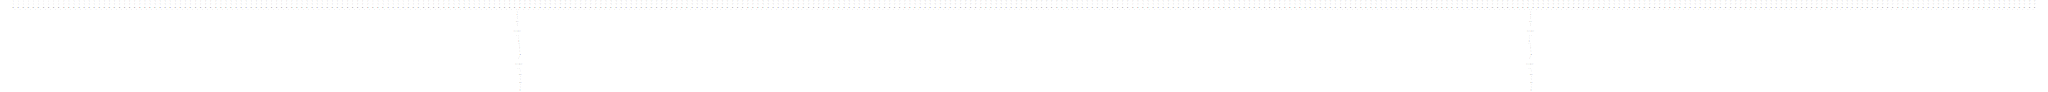

In [45]:
ddf.visualize(filename='test.svg')

In [29]:
make_df(hor, ver, dates[1], site, data_path)

,soilCO2concentrationMean,soilCO2concentrationMinimum,soilCO2concentrationMaximum,soilCO2concentrationVariance,soilCO2concentrationNumPts,soilCO2concentrationExpUncert,soilCO2concentrationStdErMean,VSWCMean,VSWCMinimum,VSWCMaximum,...,VSICNumPts,VSICExpUncert,VSICStdErMean,soilTempMean,soilTempMinimum,soilTempMaximum,soilTempVariance,soilTempNumPts,soilTempExpUncert,soilTempStdErMean
startDateTime,,,,,,,,,,,,,,,,,,,,,
2019-11-01 00:00:00+00:00,5405.495122,5386.579268,5422.882683,201.107805,6.0,76.796585,5.576415,0.186305,0.186300,0.186305,...,6.0,0.163122,0.081537,18.132366,18.118756,18.145049,0.000149,6.0,0.144666,0.004082
2019-11-01 01:00:00+00:00,5237.760217,5221.392826,5253.325435,152.794565,6.0,74.231957,4.790174,0.185663,0.185663,0.185663,...,6.0,0.216391,0.108239,18.071674,18.057848,18.085717,0.000175,6.0,0.144698,0.004437
2019-11-01 02:00:00+00:00,5072.563514,5057.312162,5087.634054,135.810811,6.0,71.858919,4.598000,0.185103,0.185103,0.185111,...,6.0,0.037216,0.018622,18.003703,17.986514,18.019838,0.000243,6.0,0.144819,0.005245
2019-11-01 03:00:00+00:00,4932.873846,4918.036410,4949.795128,153.323590,6.0,70.029487,4.815718,0.184559,0.184559,0.184559,...,6.0,0.035744,0.017897,17.932692,17.919077,17.946846,0.000177,6.0,0.144644,0.004400
2019-11-01 04:00:00+00:00,4807.335745,4792.291702,4823.662553,150.020638,6.0,68.266383,4.815766,0.183943,0.183938,0.183943,...,6.0,0.079043,0.039511,17.879532,17.865234,17.894298,0.000187,6.0,0.144638,0.004563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-30 19:00:00+00:00,3046.785714,3036.041429,3056.721429,66.003333,6.0,43.304524,3.209738,0.168724,0.168724,0.168724,...,6.0,0.030381,0.015214,14.995548,14.994119,14.996857,0.000001,6.0,0.142900,0.000437
2019-11-30 20:00:00+00:00,3053.380732,3042.599024,3064.352439,75.060683,6.0,43.478293,3.326510,0.168583,0.168583,0.168583,...,6.0,0.051049,0.025537,15.057146,15.055780,15.058537,0.000001,6.0,0.142985,0.000411
2019-11-30 21:00:00+00:00,3086.957674,3076.644419,3097.431860,66.248791,6.0,43.869070,3.158837,0.168423,0.168423,0.168423,...,6.0,0.077721,0.038674,15.107581,15.106209,15.108930,0.000001,6.0,0.143000,0.000411


In [27]:
date = dates[0]
minute = '[0-9]' * 3 + '.' + '[0-9]' * 3 + '.001' 
co2 = glob.glob(f'{data_path}/*{site}.DP1.00095.001.{minute}.*.{date}.*csv')[0]
h2o = glob.glob(f'{data_path}/*{site}.DP1.00094.001.{minute}.*.{date}.*csv')[0]
list(pd.read_csv(h2o).columns)

['startDateTime',
 'endDateTime',
 'VSWCMean',
 'VSWCMinimum',
 'VSWCMaximum',
 'VSWCVariance',
 'VSWCNumPts',
 'VSWCExpUncert',
 'VSWCStdErMean',
 'VSWCRangeFailQM',
 'VSWCRangePassQM',
 'VSWCRangeNAQM',
 'VSWCPersistenceFailQM',
 'VSWCPersistencePassQM',
 'VSWCPersistenceNAQM',
 'VSWCStepFailQM',
 'VSWCStepPassQM',
 'VSWCStepNAQM',
 'VSWCNullFailQM',
 'VSWCNullPassQM',
 'VSWCNullNAQM',
 'VSWCGapFailQM',
 'VSWCGapPassQM',
 'VSWCGapNAQM',
 'VSWCSpikeFailQM',
 'VSWCSpikePassQM',
 'VSWCSpikeNAQM',
 'VSWCValidCalFailQM',
 'VSWCValidCalPassQM',
 'VSWCValidCalNAQM',
 'VSWCAlphaQM',
 'VSWCBetaQM',
 'VSWCFinalQF',
 'VSWCFinalQFSciRvw',
 'VSICMean',
 'VSICMinimum',
 'VSICMaximum',
 'VSICVariance',
 'VSICNumPts',
 'VSICExpUncert',
 'VSICStdErMean',
 'VSICRangeFailQM',
 'VSICRangePassQM',
 'VSICRangeNAQM',
 'VSICPersistenceFailQM',
 'VSICPersistencePassQM',
 'VSICPersistenceNAQM',
 'VSICStepFailQM',
 'VSICStepPassQM',
 'VSICStepNAQM',
 'VSICNullFailQM',
 'VSICNullPassQM',
 'VSICNullNAQM',
 'VSIC

In [6]:
import dask.dataframe as dd

In [7]:
?dd.read_csv

Signature:
dd.read_csv(
    urlpath,
    blocksize='default',
    lineterminator=None,
    compression=None,
    sample=256000,
    enforce=False,
    assume_missing=False,
    storage_options=None,
    include_path_column=False,
    **kwargs,
)
Docstring:
Read CSV files into a Dask.DataFrame

This parallelizes the :func:`pandas.read_csv` function in the following ways:

- It supports loading many files at once using globstrings:

    >>> df = dd.read_csv('myfiles.*.csv')  # doctest: +SKIP

- In some cases it can break up large files:

    >>> df = dd.read_csv('largefile.csv', blocksize=25e6)  # 25MB chunks  # doctest: +SKIP

- It can read CSV files from external resources (e.g. S3, HDFS) by
  providing a URL:

    >>> df = dd.read_csv('s3://bucket/myfiles.*.csv')  # doctest: +SKIP
    >>> df = dd.read_csv('hdfs:///myfiles.*.csv')  # doctest: +SKIP
    >>> df = dd.read_csv('hdfs://namenode.example.com/myfiles.*.csv')  # doctest: +SKIP

Internally ``dd.read_csv`` uses :func:`pandas.read

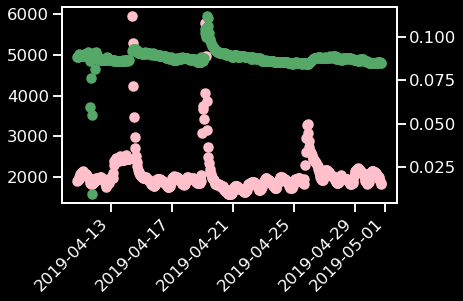

In [70]:
df = make_df('005', '501', '2019-04', 'TALL', data_path)

plt.style.use('dark_background')
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.scatter(df.index, df.soilCO2concentrationMean, c='pink')
ax2.scatter(df.index, df.VSWCMean, c='g')
fig.autofmt_xdate(rotation=45)

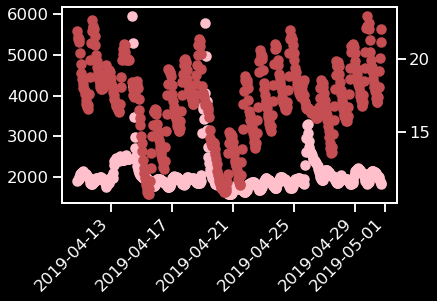

In [71]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.scatter(df.index, df.soilCO2concentrationMean, c='pink')
ax2.scatter(df.index, df.soilTempMean, c='r')
fig.autofmt_xdate(rotation=45)

Text(0.5, 0, 'CO2 (ppm?)')

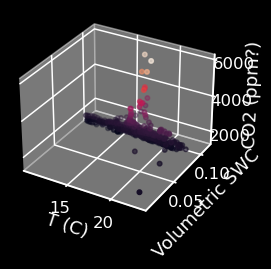

In [72]:
fig = plt.figure()
ax = plt.axes(projection='3d')

x = df.soilTempMean
y = df.VSWCMean
z = df.soilCO2concentrationMean

ax.scatter(x, y, z, c=z)

ax.set_xlabel('T (C)')
ax.set_ylabel('Volumetric SWC')
ax.set_zlabel('CO2 (ppm?)')

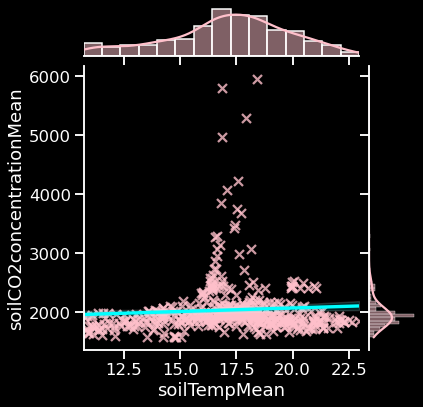

In [73]:
sns.set(style='ticks', context='talk')
plt.style.use('dark_background')
j = sns.jointplot(x='soilTempMean', y='soilCO2concentrationMean', data=df, kind = 'reg', color='pink', marker = 'x', joint_kws={'line_kws':{'color':'cyan'}})
# aack I wosh seabor would give us r and p!


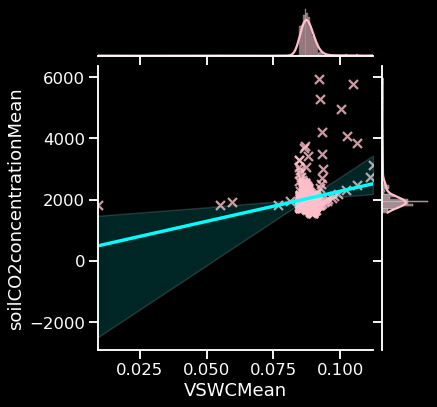

In [74]:
sns.set(style='ticks', context='talk')
plt.style.use('dark_background')
j = sns.jointplot(x='VSWCMean', y='soilCO2concentrationMean', data=df, kind = 'reg', color='pink', marker = 'x', joint_kws={'line_kws':{'color':'cyan'}})


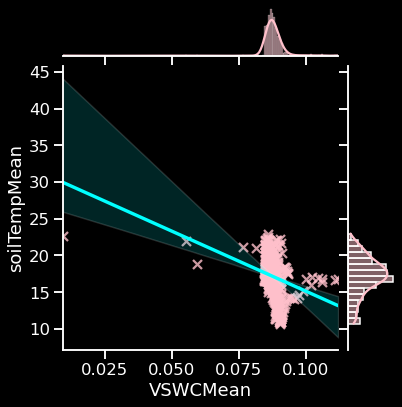

In [75]:
sns.set(style='ticks', context='talk')
plt.style.use('dark_background')
j = sns.jointplot(x='VSWCMean', y='soilTempMean', data=df, kind = 'reg', color='pink', marker = 'x', joint_kws={'line_kws':{'color':'cyan'}})


### 1) ###
Judging from all of these plots I think there might be a T sensor malfunction insome of the data. Also, double check the sensor positions to make sure the T ansd H2O sensors are lined up. Extract the actual z offset for each from the senor positions to report with each analysis.  Probably ultimately w will want to save a pdf for each sensor with graPHS AND STATISTICAL INFO.

### 2) ###

__a)__ For each dataset in the training sets split to train and validations sets.

__b)__ Create a model. validate.

__c)__ Validate on holdout sites.


In [79]:
!pip install pyarrow

     |████████████████████████████████| 17.8 MB 4.8 MB/s eta 0:00:01    |█▌                              | 819 kB 4.8 MB/s eta 0:00:04     |██████████████████▎             | 10.1 MB 4.8 MB/s eta 0:00:02


In [80]:
def make_pooled_hourly_data_parquet():
    

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.9.0
  latest version: 4.9.2

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - python-graphviz


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.12.5  |       ha878542_0         137 KB  conda-forge
    certifi-2020.12.5          |   py38h578d9bd_0         143 KB  conda-forge
    openssl-1.1.1i             |       h7f98852_0         2.1 MB  conda-forge
    python-graphviz-0.15       |     pyhd3deb0d_0          19 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.4 MB

The following packages will be UPDATED:

  ca-certificates                      2020.6.20-hecda079_0 --> 2020.12

,soilCO2concentrationMean,soilCO2concentrationMinimum,soilCO2concentrationMaximum,soilCO2concentrationVariance,soilCO2concentrationNumPts,soilCO2concentrationExpUncert,soilCO2concentrationStdErMean,VSWCMean,VSWCMinimum,VSWCMaximum,...,VSICNumPts,VSICExpUncert,VSICStdErMean,soilTempMean,soilTempMinimum,soilTempMaximum,soilTempVariance,soilTempNumPts,soilTempExpUncert,soilTempStdErMean
startDateTime,,,,,,,,,,,,,,,,,,,,,
2019-04-10 19:00:00+00:00,1887.311538,1881.911154,1892.519231,17.858077,6.0,26.718077,1.599727,0.088769,0.088538,0.089023,...,6.0,0.117115,0.058654,21.909462,21.904192,21.914808,0.000018,6.0,0.145942,0.001689
2019-04-10 20:00:00+00:00,1916.907931,1911.342414,1921.962069,16.594621,6.0,27.111724,1.593390,0.088566,0.088366,0.088759,...,6.0,0.008103,0.004069,21.503655,21.501103,21.506276,0.000005,6.0,0.145710,0.000828
2019-04-10 21:00:00+00:00,1921.062162,1915.340000,1926.505946,19.518703,6.0,27.211081,1.718816,0.088684,0.088481,0.088881,...,6.0,0.146486,0.073270,21.364135,21.362027,21.366162,0.000003,6.0,0.145670,0.000636
2019-04-10 22:00:00+00:00,1941.214737,1935.621316,1947.290263,20.281947,6.0,27.508421,1.782966,0.089903,0.088866,0.091376,...,6.0,0.042184,0.021132,21.384211,21.381947,21.386289,0.000003,6.0,0.145700,0.000653
2019-04-10 23:00:00+00:00,1997.735000,1993.060625,2003.103125,16.309687,6.0,28.235625,1.578638,0.090125,0.089450,0.090725,...,6.0,0.021875,0.011000,21.186125,21.181938,21.190062,0.000010,6.0,0.145606,0.001225
